## References

* Deep Learning with python, second edition. Chapter 10.

## Install libraries

In [ ]:
!pip3 install -q tensorflow keras

## Data

### Download

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip -y jena_climate_2009_2016.csv.zip

--2023-12-03 18:46:50--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.232.56, 54.231.227.184, 54.231.170.240, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.232.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.2’

jena_climate_2009_2 100%[===================>]  12,94M  3,10MB/s    in 6,5s    

2023-12-03 18:46:57 (2,00 MB/s) - ‘jena_climate_2009_2016.csv.zip.2’ saved [13565642/13565642]

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create n

### Load

Load data:

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In this dataset, 14 different quantities (such as temperature, pressure, humidity, and wind direction) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

In [2]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

`temperature` holds the observed values of the data that we want to predict and `raw_data` holds all the numeric variables, including temperature.

### Plot the data

Plot the temperature over time:

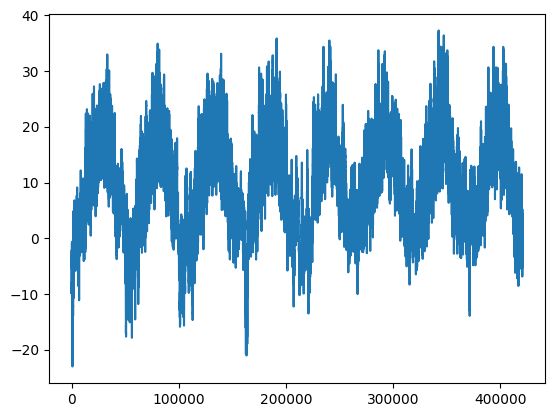

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

First 10 days of temperature data. 24 * 6 = 144 data points per day.

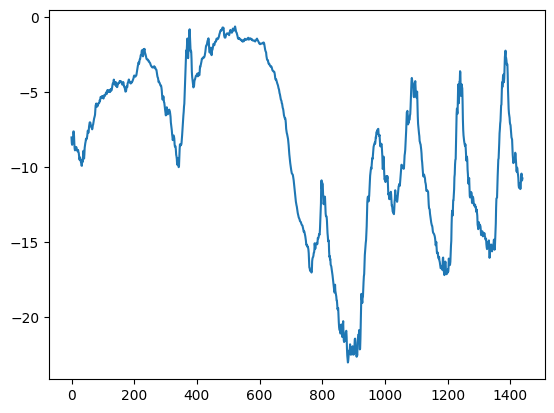

In [ ]:
plt.plot(range(1440), temperature[:1440])

## Task

Given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

This notebook contains sample code for:

* Feedforward neural network
* 1D convolution neural network
* 3 variations of recurring neural network

Optimize the three classes of models above to give the best MAE. In addtion, use a transformer to compete in terms of MAE.

This [page](https://keras.io/examples/timeseries/timeseries_classification_transformer/) contains a reference of using a Transformer for time-series data.

The sample code below is a starting point. Your job is to extract the most value out of the models mentioned above. You are free to go beyond what is requested here and try out different models if you like.

Return a `.ipynb` containing the code (one section per model) and start the document with a summary of the models you tried and their respective MAEs in a table.

**Deadline**: 05/12

### Prepare the data

Decide the number of data points that will be assigned to training, validation and test sets.

In [3]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Normalize the data.

In [4]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [5]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_sequence = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2
)

In [6]:
# print("dummy_sequence:", dummy_sequence)

for inputs, targets in dummy_sequence:
    print("inputs:", inputs.numpy(), "targets:", targets.numpy())

inputs: [[0 1 2]
 [1 2 3]] targets: [3 4]
inputs: [[2 3 4]
 [3 4 5]] targets: [5 6]
inputs: [[4 5 6]] targets: [7]


Create `tensorflow.data.Dataset` for training, validation and test splits:

In [7]:
import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

Check the input dimensions:

In [8]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## FNN improvement

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation="relu")(x)  # Removed regularization to see if it was hindering learning

x = layers.BatchNormalization()(x)

x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model_nn = keras.Model(inputs, outputs)

# Compiling the model with a different optimizer and learning rate scheduler
optimizer = keras.optimizers.Adam()
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

model_nn.compile(optimizer=optimizer,
              loss='mae',
              metrics=['mae'])

# Including early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history_nn = model_nn.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
819/819 [==============================] - 11s 13ms/step - loss: 4.9777 - mae: 4.9777 - val_loss: 2.9738 - val_mae: 2.9738 - lr: 1.0000e-04
Epoch 2/50
819/819 [==============================] - 10s 12ms/step - loss: 2.6390 - mae: 2.6390 - val_loss: 2.4453 - val_mae: 2.4453 - lr: 1.1220e-04
Epoch 3/50
819/819 [==============================] - 10s 12ms/step - loss: 2.3407 - mae: 2.3407 - val_loss: 2.4377 - val_mae: 2.4377 - lr: 1.2589e-04
Epoch 4/50
819/819 [==============================] - 10s 12ms/step - loss: 2.2187 - mae: 2.2187 - val_loss: 2.4334 - val_mae: 2.4334 - lr: 1.4125e-04
Epoch 5/50
819/819 [==============================] - 10s 12ms/step - loss: 2.1031 - mae: 2.1031 - val_loss: 2.5196 - val_mae: 2.5196 - lr: 1.5849e-04
Epoch 6/50
819/819 [==============================] - 10s 12ms/step - loss: 2.0238 - mae: 2.0238 - val_loss: 2.4898 - val_mae: 2.4898 - lr: 1.7783e-04
Epoch 7/50
819/819 [==============================] - 10s 12ms/step - loss: 1.9568 - mae: 1.95

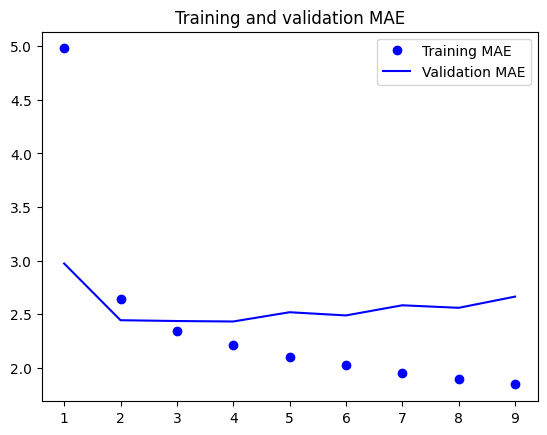

405/405 [==============================] - 3s 8ms/step - loss: 2.5525 - mae: 2.5525
Test MAE: 2.55


In [ ]:
import matplotlib.pyplot as plt

loss_nn = history_nn.history["mae"]
val_loss_nn = history_nn.history["val_mae"]
epochs = range(1, len(loss_nn) + 1)
plt.figure()
plt.plot(epochs, loss_nn, "bo", label="Training MAE")
plt.plot(epochs, val_loss_nn, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_nn.evaluate(test_dataset)[1]:.2f}")

## 1D convolution neural network improvement

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Increase the number of filters and adjust the kernel size
x = layers.Conv1D(16, 24, activation="relu", padding='same')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.BatchNormalization()(x)  # Added batch normalization

x = layers.Conv1D(32, 12, activation="relu", padding='same')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.3)(x)  # Added dropout

x = layers.Conv1D(64, 6, activation="relu", padding='same')(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1)(x)
model_cnn = keras.Model(inputs, outputs)

# Compiling the model with a different optimizer and learning rate scheduler
optimizer = keras.optimizers.Adam()
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

model_cnn.compile(optimizer=optimizer,
              loss='mae',
              metrics=['mae'])

# Including early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history_cnn = model_cnn.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
241/819 [=======>......................] - ETA: 16s - loss: 5.4676 - mae: 5.4676

819/819 [==============================] - 30s 35ms/step - loss: 4.0819 - mae: 4.0819 - val_loss: 3.1047 - val_mae: 3.1047 - lr: 1.0000e-04
Epoch 2/50
819/819 [==============================] - 29s 35ms/step - loss: 3.1622 - mae: 3.1622 - val_loss: 2.8454 - val_mae: 2.8454 - lr: 1.1220e-04
Epoch 3/50
819/819 [==============================] - 29s 35ms/step - loss: 2.8973 - mae: 2.8973 - val_loss: 2.7848 - val_mae: 2.7848 - lr: 1.2589e-04
Epoch 4/50
819/819 [==============================] - 29s 35ms/step - loss: 2.7360 - mae: 2.7360 - val_loss: 2.7182 - val_mae: 2.7182 - lr: 1.4125e-04
Epoch 5/50
819/819 [==============================] - 29s 35ms/step - loss: 2.6207 - mae: 2.6207 - val_loss: 2.6397 - val_mae: 2.6397 - lr: 1.5849e-04
Epoch 6/50
819/819 [==============================] - 29s 35ms/step - loss: 2.5363 - mae: 2.5363 - val_loss: 2.5976 - val_mae: 2.5976 - lr: 1.7783e-04
Epoch 7/50
819/819 [==============================] - 29s 35ms/step - loss: 2.4695 - mae: 2.4695 - val_lo

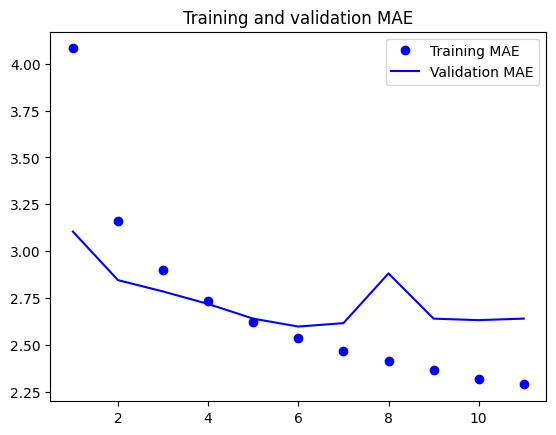

405/405 [==============================] - 8s 19ms/step - loss: 2.8487 - mae: 2.8487
Test MAE: 2.85


In [ ]:
loss_cnn = history_cnn.history["mae"]
val_loss_cnn = history_cnn.history["val_mae"]
epochs = range(1, len(loss_cnn) + 1)
plt.figure()
plt.plot(epochs, loss_cnn, "bo", label="Training MAE")
plt.plot(epochs, val_loss_cnn, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_cnn.evaluate(test_dataset)[1]:.2f}")

## RNN Improvement

In [12]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
x = layers.Dense(16, activation='relu')(x)  # Added dense layer
outputs = layers.Dense(1)(x)
model_rnn = keras.Model(inputs, outputs)
optimizer = optimizers.RMSprop(learning_rate=0.001)  # Set lr to 0.001
model_rnn.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Added early stop
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_rnn = model_rnn.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)
print(f"Test MAE: {model_rnn.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
819/819 [==============================] - 136s 162ms/step - loss: 21.5434 - mae: 3.2743 - val_loss: 9.7864 - val_mae: 2.4281
Epoch 2/20
819/819 [==============================] - 131s 160ms/step - loss: 9.7571 - mae: 2.4273 - val_loss: 9.4819 - val_mae: 2.3972
Epoch 3/20
819/819 [==============================] - 107s 131ms/step - loss: 9.3604 - mae: 2.3786 - val_loss: 9.8953 - val_mae: 2.4522
Epoch 4/20
819/819 [==============================] - 130s 158ms/step - loss: 8.9952 - mae: 2.3326 - val_loss: 10.1641 - val_mae: 2.4903
Epoch 5/20
405/405 [==============================] - 24s 59ms/step - loss: 10.1221 - mae: 2.4814
Test MAE: 2.48


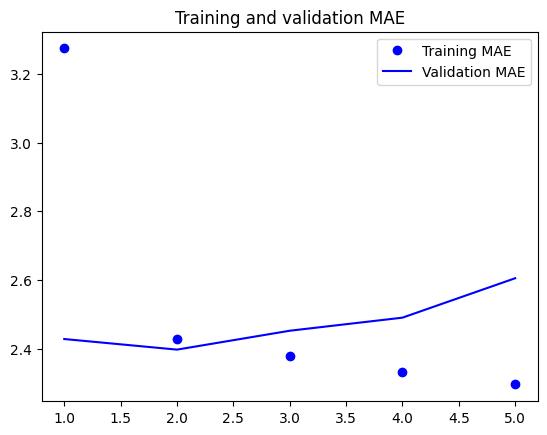

405/405 [==============================] - 28s 68ms/step - loss: 10.1221 - mae: 2.4814
Test MAE: 2.48


In [16]:
loss_rnn = history_rnn.history["mae"]
val_loss_rnn = history_rnn.history["val_mae"]
epochs = range(1, len(loss_rnn) + 1)
plt.figure()
plt.plot(epochs, loss_rnn, "bo", label="Training MAE")
plt.plot(epochs, val_loss_rnn, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_rnn.evaluate(test_dataset)[1]:.2f}")

## Transformer

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 KB 3.5 MB/s eta 0:00:00a 0:00:01


In [ ]:
import tensorflow as tf
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = layers.Add()([x, inputs])  # Skip Connection

    # Feed Forward Network
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return layers.Add()([x, res])  # Skip Connection

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0, mlp_units=[], mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # MLP head
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for units in mlp_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)

    return keras.Model(inputs, outputs)

input_shape = (120, 14)  # 120 timesteps, 14 features

model_transformer = build_transformer_model(
    input_shape=input_shape,
    head_size=32,
    num_heads=2,
    ff_dim=32,
    num_transformer_blocks=2,
    mlp_units=[128],
    dropout=0.05,
    mlp_dropout=0.1
)

model_transformer.compile(optimizer="adam", loss="mae", metrics=["mae"])

# Compiling the model with a different optimizer and learning rate scheduler
optimizer = keras.optimizers.Adam()
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

# Including early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history_transformer = model_transformer.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
819/819 [==============================] - 353s 428ms/step - loss: 4.1108 - mae: 4.1108 - val_loss: 2.7971 - val_mae: 2.7971 - lr: 1.0000e-04
Epoch 2/50
819/819 [==============================] - 334s 407ms/step - loss: 2.7589 - mae: 2.7589 - val_loss: 2.4928 - val_mae: 2.4928 - lr: 1.1220e-04
Epoch 3/50
819/819 [==============================] - 302s 368ms/step - loss: 2.5267 - mae: 2.5267 - val_loss: 2.4316 - val_mae: 2.4316 - lr: 1.2589e-04
Epoch 4/50
819/819 [==============================] - 303s 370ms/step - loss: 2.4216 - mae: 2.4216 - val_loss: 2.4067 - val_mae: 2.4067 - lr: 1.4125e-04
Epoch 5/50
819/819 [==============================] - 323s 394ms/step - loss: 2.3589 - mae: 2.3589 - val_loss: 2.4006 - val_mae: 2.4006 - lr: 1.5849e-04
Epoch 6/50
819/819 [==============================] - 492s 600ms/step - loss: 2.3069 - mae: 2.3069 - val_loss: 2.4277 - val_mae: 2.4277 - lr: 1.7783e-04
Epoch 7/50
819/819 [==============================] - 438s 535ms/step - loss: 2.27

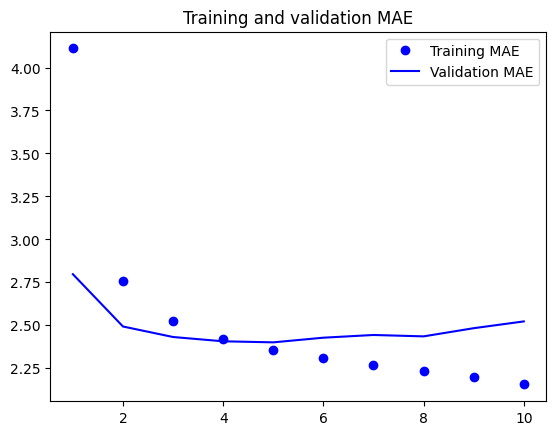

405/405 [==============================] - 60s 147ms/step - loss: 2.5182 - mae: 2.5182
Test MAE: 2.52


In [ ]:
loss = history_transformer.history["mae"]
val_loss = history_transformer.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_transformer.evaluate(test_dataset)[1]:.2f}")

# Resultados

| Model | Original MAE | Improved MAE |
|-|-:|-:|
| FNN | 2.79 | 2.58 |
| CNN | 3.08 | 2.85 |
| RNN | 2.58 | 2.48 |
| Transformer |  | 2.52 |

## Feedforward Neural Network


Já se era esperado, pela descrição do problema, que a rede neural feedforward não fosse performar bem. A rede neural feedforward é uma rede neural que não possui memória. Por isso, ela, em geral, não é adequada para problemas relacionados a series temporais. Entretanto, executamos alguns testes para ao menos atingir o MAE encontrado no modelo baseline (conjunto de testes: 2.62). O melhor resultado foi encontrado executando as seguintes mudanças:
- Aumento da Capacidade do modelo: A primeira camada densa foi ampliada de 16 para 32 neurônios.
- Adição da normalização em lote
- Adição de uma outra camada densa com 16 neurônios
- Mudança de otimizador para RMSprop
- Adição de um Agendador de Taxa de Aprendizado
- Implementação de Early Stopping
- Aumento no número de épocas de treinamento
<br><br>
Executando essas mudanças, o modelo conseguiu atingir um MAE de 2.58 no conjunto de testes, o que é um resultado ligeiramete melhor que o modelo baseline.

#### Best-Model FFNN Summary

In [ ]:
model_nn.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 flatten_29 (Flatten)        (None, 1680)              0         
                                                                 
 dense_87 (Dense)            (None, 32)                53792     
                                                                 
 batch_normalization_20 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_88 (Dense)            (None, 16)                528       
                                                                 
 dense_89 (Dense)            (None, 1)                 17        
                                                          

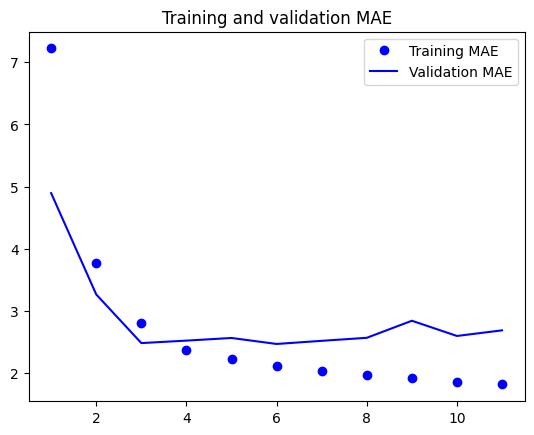

405/405 [==============================] - 6s 13ms/step - loss: 2.6211 - mae: 2.6211
Test MAE: 2.62
Validation MAE: 2.69


In [ ]:
import matplotlib.pyplot as plt

loss = history_nn.history["mae"]
val_loss = history_nn.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_nn.evaluate(test_dataset)[1]:.2f}")
print(f"Validation MAE: {history_nn.history['val_mae'][-1]:.2f}")

## Convolutional Neural Network


Assim como na classe de modelos da rede neural feedforward, a CNN é uma rede neural que não possui memória. Por isso, ela, em geral, também não é adequada para problemas relacionados a series temporais. Entretanto, executamos alguns testes para ao menos atingir o MAE encontrado no modelo baseline (conjunto de testes: 2.62). O melhor resultado foi encontrado executando as seguintes mudanças:
- Aumento na Quantidade de Filtros.
- Mudança no Tamanho dos Filtros: O tamanho dos filtros permaneceu o mesmo, mas ao utilizar padding='same', garante-se que o tamanho da saída de cada camada convolucional seja igual ao da entrada, permitindo que a rede mantenha a resolução espacial ao longo de suas camadas.
- Normalização em Lote: Foi adicionada uma camada de Batch Normalization após a primeira camada convolucional.
- Dropout: A inclusão de Dropout após a segunda camada convolucional visa reduzir o sobreajuste.
- Aumento na Complexidade das Camadas Convolucionais: As camadas convolucionais foram expandidas para ter uma hierarquia de 16, 32 e 64 filtros, respectivamente. Isso é uma tentativa de permitir que a rede aprenda hierarquias mais complexas de características.
- Alteração do Otimizador: O modelo original usava o otimizador RMSprop, enquanto o atualizado está utilizando o Adam.
- Agendador de Taxa de Aprendizado.
- Parada Antecipada (Early Stopping).
- Aumento no Número de Épocas.
<br><br>
Executando essas mudanças, o modelo conseguiu atingir um MAE de 2.85 no conjunto de testes, o que é uma melhora em relação ao modelo original.

#### Best-Model CNN Summary

In [ ]:
model_cnn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 120, 16)           5392      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 60, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 60, 16)           64        
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 60, 32)            6176      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 30, 32)           0   

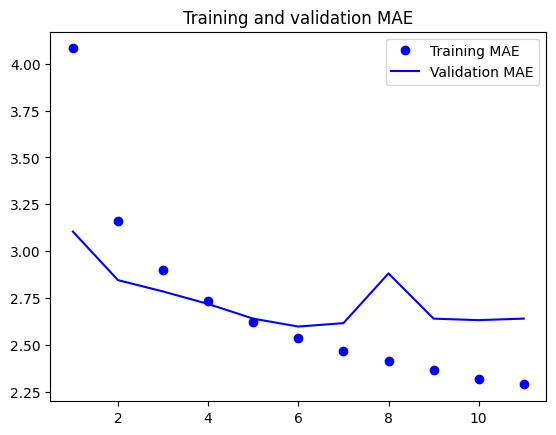

405/405 [==============================] - 9s 21ms/step - loss: 2.8487 - mae: 2.8487
Test MAE: 2.85


In [ ]:
loss_cnn = history_cnn.history["mae"]
val_loss_cnn = history_cnn.history["val_mae"]
epochs = range(1, len(loss_cnn) + 1)
plt.figure()
plt.plot(epochs, loss_cnn, "bo", label="Training MAE")
plt.plot(epochs, val_loss_cnn, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_cnn.evaluate(test_dataset)[1]:.2f}")

## Recurrent Neural Network

Para a classe RNN, foram testadas várias arquiteturas e configurações, a fim de diminuir ao máximo o MAE. Algumas dessas mudanças fizeram o modelo alcançar um resultado melhor do que as versões originais de RNN, sendo que o melhor modelo testado possuía as seguintes características:

- Célula LSTM com 16 neurônios.
- Camada densa com 16 neurônios e função de ativação ReLu.
- Otimizador RMSprop com learning rate 0.001.
- Aplicação de Early Stopping.

Com essas mudanças, o modelo conseguiu atingir um MAE de 2.48 no conjunto de testes, sendo melhor do que as três versões originais de RNN.

#### Best-Model RNN Summary

In [17]:
model_rnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2273 (8.88 KB)
Trainable params: 2273 (8.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


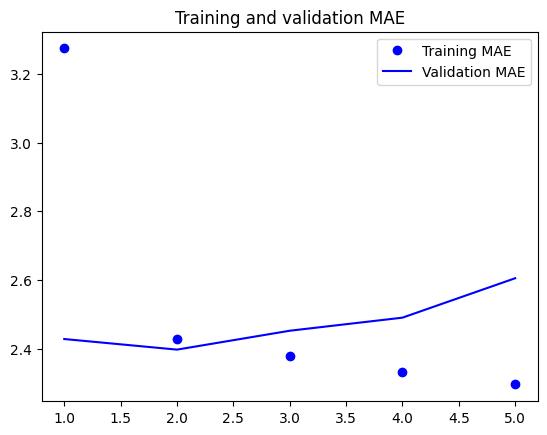

405/405 [==============================] - 35s 84ms/step - loss: 10.1221 - mae: 2.4814
Test MAE: 2.48


In [18]:
loss_rnn = history_rnn.history["mae"]
val_loss = history_rnn.history["val_mae"]
epochs = range(1, len(loss_rnn) + 1)
plt.figure()
plt.plot(epochs, loss_rnn, "bo", label="Training MAE")
plt.plot(epochs, val_loss_rnn, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_rnn.evaluate(test_dataset)[1]:.2f}")

## Transformer

Um modelo Transformer é capaz de identificar padrões temporais complexos, o que pode ser particularmente útil para esse tipo de previsão. Treinamos algumas configurações diferentes de Transformers, e o melhor resultado foi encontrado executando as seguintes configurações:
- head_size=32: Escolhido para as camadas de atenção multi-head. Cada head de atenção tem dimensão 32, o que determina o tamanho da representação de cada elemento da sequência na atenção.
- num_heads=2: O modelo utiliza duas heads de atenção em cada camada de atenção multi-head, permitindo que o modelo foque em diferentes aspectos da sequência simultaneamente
- ff_dim=32: A dimensão da rede feed-forward interna de cada bloco Transformer é 32. Esta rede permite processamento adicional dos dados após a etapa de atenção.
- num_transformer_blocks=2: O modelo consiste em dois blocos Transformer. Cada bloco contém uma camada de atenção seguida por uma rede feed-forward.
- mlp_units=[128]: Após os blocos Transformer, uma rede MLP com uma camada oculta de 128 unidades é usada para processamento adicional antes da camada de saída.
- dropout=0.05 e mlp_dropout=0.1: Taxas de dropout usadas para regularização nas camadas de atenção e na rede MLP, respectivamente, para prevenir o sobreajuste.
- Otimizador: Adam.
- Learning Rate Scheduler: Um agendador de taxa de aprendizado foi utilizado para ajustar a taxa de aprendizado durante o treinamento.
- Early Stopping configurado com patience=5.



#### Best-Model Transformer Summary

In [ ]:
model_transformer.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 120, 14)]    0           []                               
                                                                                                  
 layer_normalization_65 (LayerN  (None, 120, 14)     28          ['input_17[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_36 (Multi  (None, 120, 14)     3790        ['layer_normalization_65[0][0]', 
 HeadAttention)                                                   'layer_normalization_65[0][0]'] 
                                                                                            

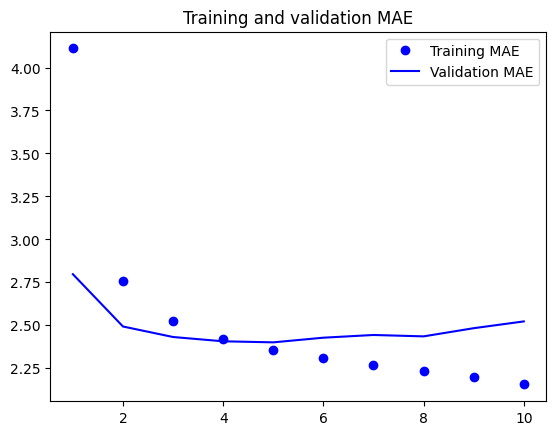

405/405 [==============================] - 56s 139ms/step - loss: 2.5182 - mae: 2.5182
Test MAE: 2.52


In [ ]:
loss_transformer = history_transformer.history["mae"]
val_loss_transformer = history_transformer.history["val_mae"]
epochs = range(1, len(loss_transformer) + 1)
plt.figure()
plt.plot(epochs, loss_transformer, "bo", label="Training MAE")
plt.plot(epochs, val_loss_transformer, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_transformer.evaluate(test_dataset)[1]:.2f}")